# Introduction
For this implementation, I will be using an ARIMA(p,d,q) model with parameters p, d and q, which is usually used for time-series data.
* p = number of autoregressive terms
* d = number of nonseasonal differences needed for stationarity
* q = number of lagged forecast errors in the prediction equation

In [3]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.8 MB/s eta 0:00:0000:0100:010m


In [4]:
#Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
%matplotlib inline

The "NVDA.csv" file contains NVDA daily stock prices over the last 5 years, starting from 23 October 2017 to 21 October 2022.

In [5]:
#Read in the data from the csv file containing NVDA stock price over the last 5 years
nvda = pd.read_csv("../input/nvidia-stock-price/NVDA.csv", index_col = "Date", parse_dates = True)
data = pd.read_csv("../input/nvidia-stock-price/NVDA.csv", parse_dates = True)
nvda.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-23,49.445000,49.712502,48.950001,49.154999,48.637699,42869600
2017-10-24,49.247501,49.687500,48.985001,49.669998,49.147301,40724400
2017-10-25,49.270000,49.805000,47.792500,48.415001,47.905502,82816000
2017-10-26,48.695000,49.040001,48.452499,48.922501,48.407658,32274400
2017-10-27,49.450001,50.467499,49.187500,50.465000,49.933922,57219200


# Data Visualization

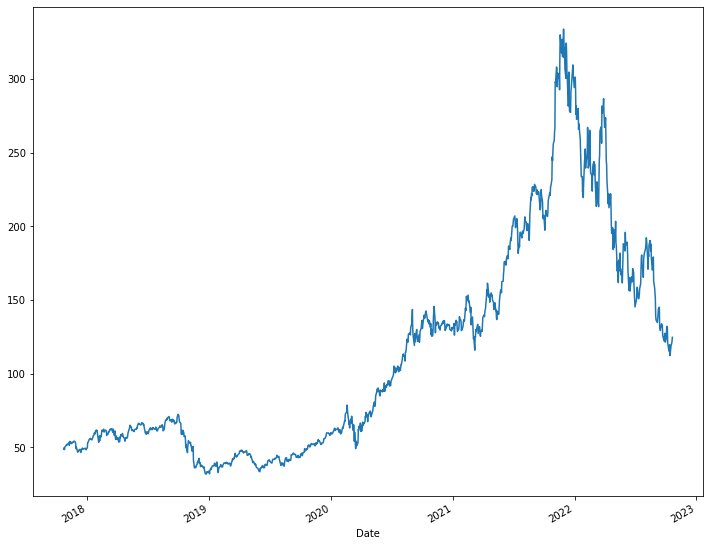

In [6]:
# Plot and show the time series on axis ax1
fig, ax1 = plt.subplots()
nvda["Close"].plot(ax=ax1, figsize=(12,10))
plt.show()

# Stationary Test Using Augmented Dicky Fuller Test

In [7]:
from statsmodels.tsa.stattools import adfuller
def adf_test(nvda):
     dftest = adfuller(nvda, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(nvda['Close'])

1. ADF :  -1.2493704686773712
2. P-Value :  0.6520056791207548
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 1243
5. Critical Values :
	 1% :  -3.435621806786881
	 5% :  -2.8638680226791444
	 10% :  -2.5680094689100477


p-value > 0.05, so the data is not stationary.

# Split into Test and Train Data

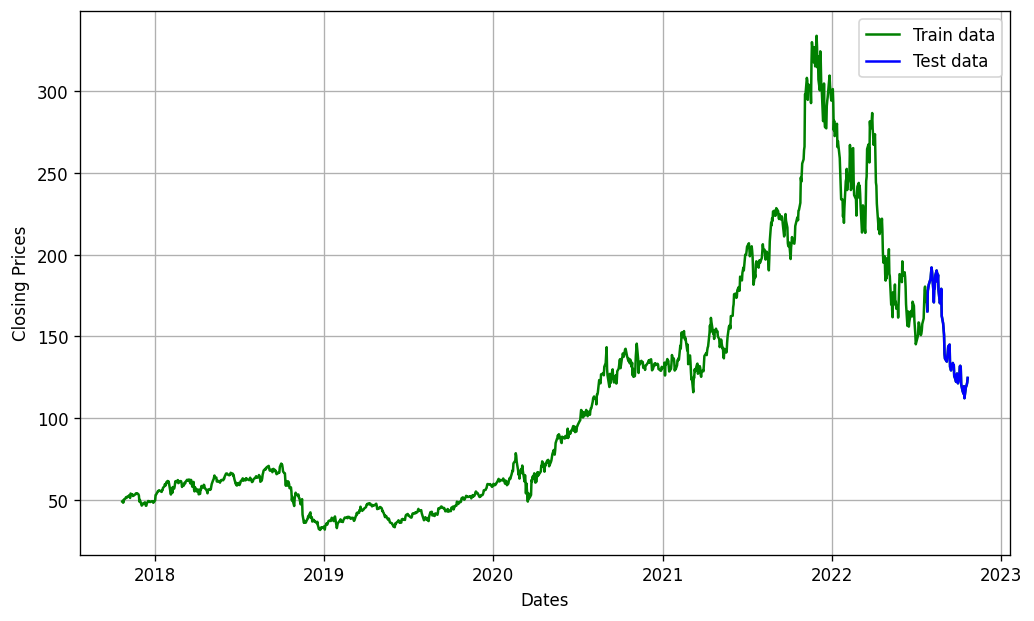

In [75]:
train_data = nvda["Close"][:int(len(nvda)*0.95)]
test_data = nvda["Close"][int(len(nvda)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(nvda["Close"], 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# Finding value of d paramater

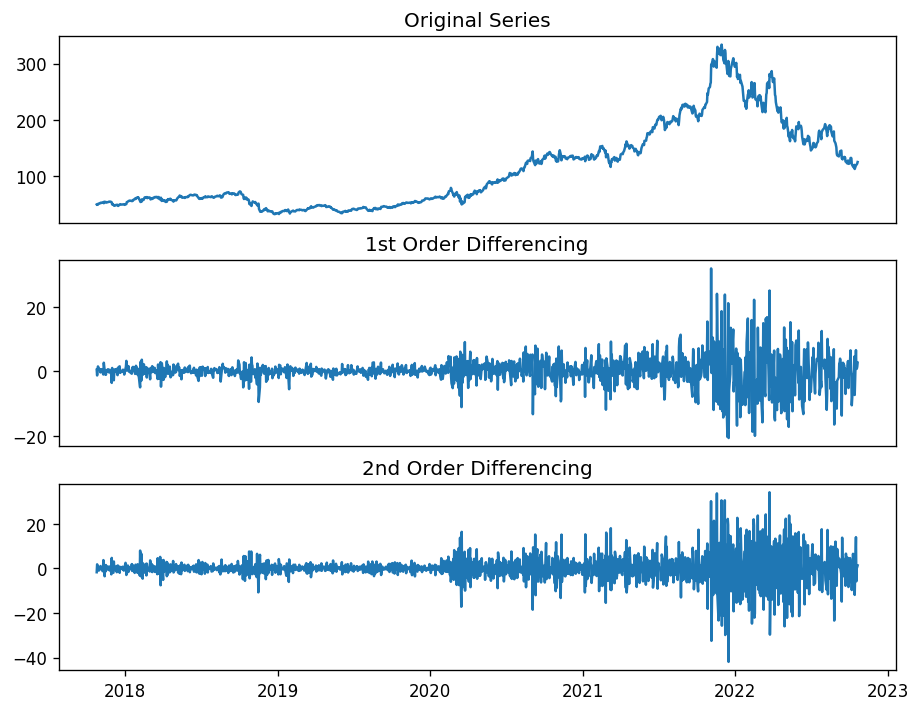

In [66]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(nvda.Close); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(nvda.Close.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(nvda.Close.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

The data became more stationary after 1st order differencing, and after 2nd order differencing it just generated more noise. We can therefore select d = 1.

# Finding value of p using PACF

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


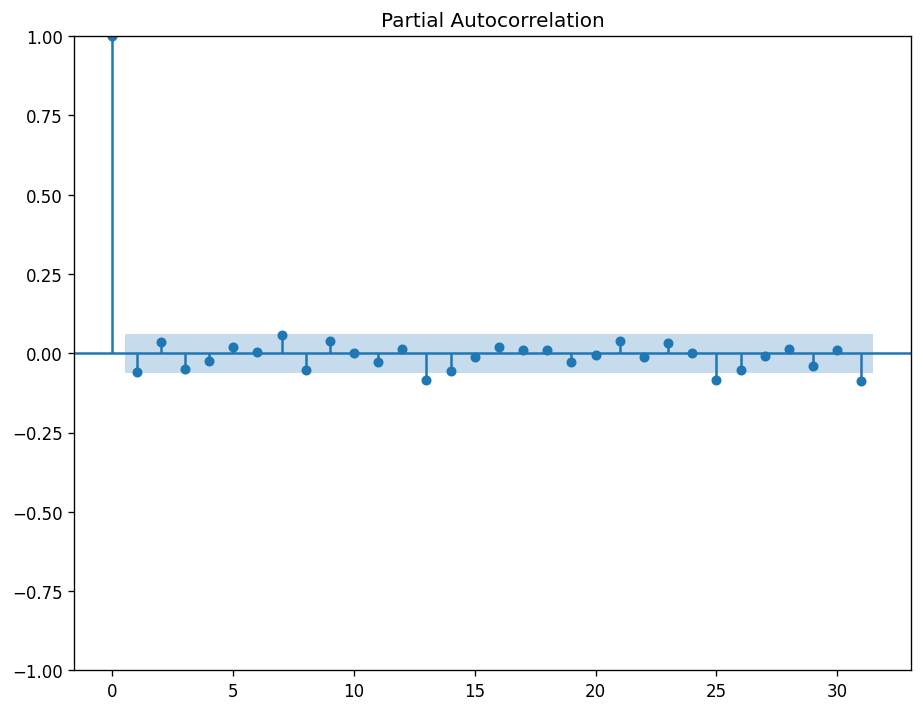

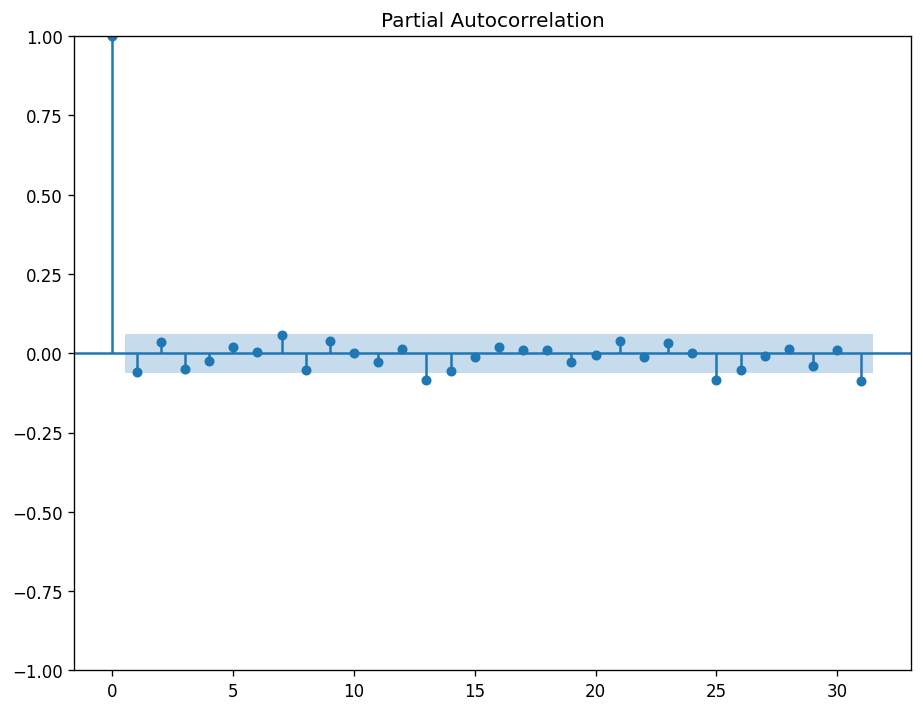

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data.diff().dropna())

p = 1 since first lag is significantly far away from the confidence interval.

# Finding value of q using ACF plot

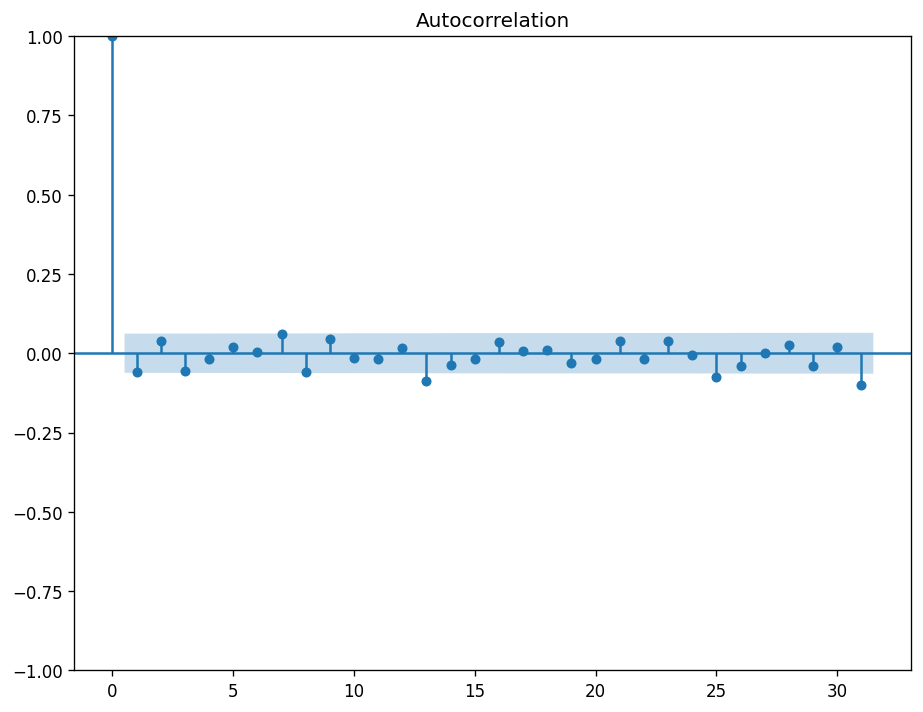

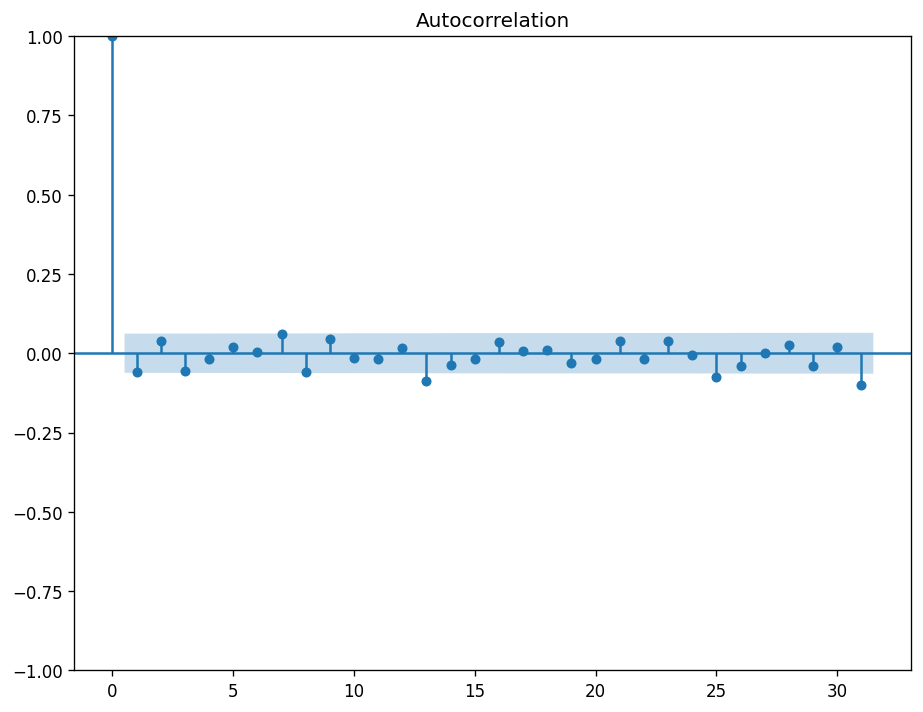

In [37]:
plot_acf(train_data.diff().dropna())

Hence, q = 1

# Building SARIMA model

In [76]:
import statsmodels.api as sm
import warnings

p,d,q = 1,1,1

model = sm.tsa.statespace.SARIMAX(train_data, order=(p,d,q), seasonal_order = (p,d,q,12))
model = model.fit()
print(model.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04267D+00    |proj g|=  6.03829D-02

At iterate    5    f=  2.93250D+00    |proj g|=  1.67662D-02

At iterate   10    f=  2.92064D+00    |proj g|=  7.89572D-03

At iterate   15    f=  2.91943D+00    |proj g|=  1.09406D-03

At iterate   20    f=  2.91935D+00    |proj g|=  3.89388D-03

At iterate   25    f=  2.91926D+00    |proj g|=  4.83186D-04

At iterate   30    f=  2.91925D+00    |proj g|=  3.27258D-04

At iterate   35    f=  2.91925D+00    |proj g|=  7.91685D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

# Make Predictions on Test Set

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


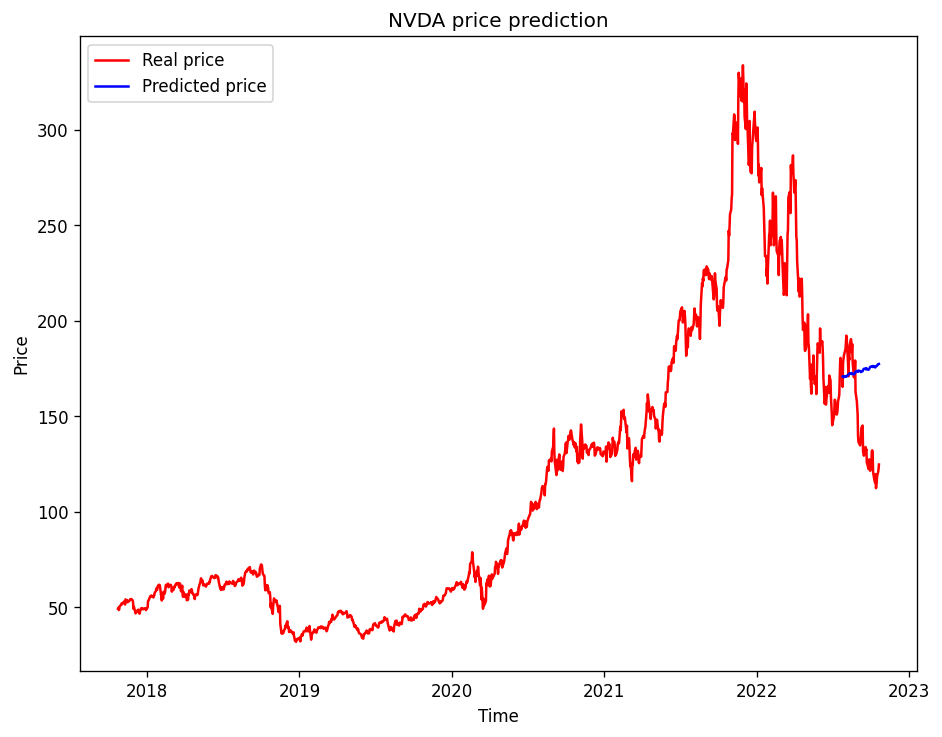

In [103]:
predicted_stock_price = model.predict(len(train_data), len(train_data) + len(test_data)-1)
predicted_stock_price = predicted_stock_price.set_axis(test_data.index)
predicted_stock_price

plt.plot(nvda["Close"], color = "red", label = "Real price")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted price")
plt.title("NVDA price prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

The model is understandably late in picking up sharp trends such as a sudden decrease in price, which is understandable given the short time frame of the test data. However, it is still able to identify smoother trends. Now, we repeat the process for the new dates 24 October - 4 November.

In [128]:
preds = model.predict(len(nvda), len(nvda)+11)
preds

df = pd.DataFrame(preds)
df
#drop the rows containing 29 and 30 October (non-trading days)

df.columns = ["Close"]
df.reset_index(drop=True, inplace=True)
df.index.names = ["index"]
df = df.drop(5)
df = df.drop(6)
df.reset_index(drop=True, inplace=True)
df.index.names = ["index"]
df
df.to_csv('MarioFranciscoMontana_Impl_2.csv')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
